# Task for Today  

***

## 911 Call Type Prediction  

Given *data about 911 calls*, let's try to predict the **type** of a given call.  
  
We will use a multi-input TensorFlow neural network to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
data = pd.read_csv('../input/montcoalert/911.csv', nrows=50000)

In [3]:
data

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1
...,...,...,...,...,...,...,...,...,...
49995,40.052428,-75.120794,CHELTENHAM AVE & WALNUT PARK DR; CHELTENHAM; ...,19012.0,EMS: HEMORRHAGING,2016-04-18 13:21:55,CHELTENHAM,CHELTENHAM AVE & WALNUT PARK DR,1
49996,40.254768,-75.660459,SHOEMAKER RD & ROBINSON ST; POTTSTOWN; 2016-04...,19464.0,Traffic: VEHICLE ACCIDENT -,2016-04-18 13:21:27,POTTSTOWN,SHOEMAKER RD & ROBINSON ST,1
49997,40.069832,-75.316295,CONSHOHOCKEN STATE RD & SCHUYLKILL EXPY OVERPA...,NaN,Fire: RESCUE - ELEVATOR,2016-04-18 13:30:04,WEST CONSHOHOCKEN,CONSHOHOCKEN STATE RD & SCHUYLKILL EXPY OVERPASS,1
49998,40.289027,-75.399590,HARLEYSVILLE PIKE & MAIN ST; LOWER SALFORD; S...,19438.0,EMS: RESPIRATORY EMERGENCY,2016-04-18 13:35:02,LOWER SALFORD,HARLEYSVILLE PIKE & MAIN ST,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        50000 non-null  float64
 1   lng        50000 non-null  float64
 2   desc       50000 non-null  object 
 3   zip        43796 non-null  float64
 4   title      50000 non-null  object 
 5   timeStamp  50000 non-null  object 
 6   twp        49982 non-null  object 
 7   addr       50000 non-null  object 
 8   e          50000 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 3.4+ MB


# Preprocessing

In [5]:
data.isna().sum()

lat             0
lng             0
desc            0
zip          6204
title           0
timeStamp       0
twp            18
addr            0
e               0
dtype: int64

In [6]:
{column: len(data[column].unique()) for column in data.columns}

{'lat': 11123,
 'lng': 11127,
 'desc': 49981,
 'zip': 99,
 'title': 100,
 'timeStamp': 48351,
 'twp': 69,
 'addr': 15684,
 'e': 1}

In [7]:
def get_sequences(texts, vocab_length=10000):
    tokenizer = Tokenizer(num_words=vocab_length)
    tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(sequence) for sequence in sequences])
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [8]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
        
    return df

In [9]:
def preprocess_inputs(df):
    
    # Drop e column (only 1 value)
    df = df.drop('e', axis=1)
    
    # Create label column and drop the title column
    df['type'] = df['title'].apply(lambda x: re.search(r'^\w+', x).group(0))
    df = df.drop('title', axis=1)
    
    # Create date/time features
    df['timeStamp'] = pd.to_datetime(df['timeStamp'])
    df['year'] = df['timeStamp'].apply(lambda x: x.year)
    df['month'] = df['timeStamp'].apply(lambda x: x.month)
    df['day'] = df['timeStamp'].apply(lambda x: x.day)
    df['hour'] = df['timeStamp'].apply(lambda x: x.hour)
    df['minute'] = df['timeStamp'].apply(lambda x: x.minute)
    df['second'] = df['timeStamp'].apply(lambda x: x.second)
    df = df.drop('timeStamp', axis=1)
    
    # Get sequences for desc and addr columns (and drop original columns)
    vocab_length = 10000
    desc_sequences = get_sequences(df['desc'], vocab_length=vocab_length)
    addr_sequences = get_sequences(df['addr'], vocab_length=vocab_length)
    df = df.drop(['desc', 'addr'], axis=1)
    
    # One-hot encode remaining categorical columns (zip and twp)
    df = onehot_encode(df, columns=['zip', 'twp'], prefixes=['z', 't'])
    
    # Split df into X and y 
    y = df['type'].copy()
    X = df.drop('type', axis=1).copy()
    
    # Map labels to integers
    label_mapping = {'EMS': 0, 'Traffic': 1, 'Fire': 2}
    y = y.replace(label_mapping)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, desc_sequences, addr_sequences, y

In [10]:
X, desc_sequences, addr_sequences, y = preprocess_inputs(data)

In [11]:
X

,lat,lng,year,month,day,hour,minute,second,z_17752.0,z_18036.0,...,t_UPPER MORELAND,t_UPPER POTTSGROVE,t_UPPER PROVIDENCE,t_UPPER SALFORD,t_WEST CONSHOHOCKEN,t_WEST NORRITON,t_WEST POTTSGROVE,t_WHITEMARSH,t_WHITPAIN,t_WORCESTER
0,1.481139,-1.627002,-2.305715,2.223811,-0.669445,0.696652,-1.120381,1.297162,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
1,1.050821,0.336056,-2.305715,2.223811,-0.669445,0.696652,-0.025644,-0.496784,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
2,-0.428581,-0.205190,-2.305715,2.223811,-0.669445,0.169809,0.550533,-0.496784,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
3,-0.482933,-0.152723,-2.305715,2.223811,-0.669445,0.521037,1.011475,0.371254,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
4,0.979819,-1.763755,-2.305715,2.223811,-0.669445,0.521037,1.530034,1.297162,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-1.171679,1.228176,0.433705,0.053239,0.266348,-0.005806,-0.486586,1.470769,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
49996,1.015226,-2.117839,0.433705,0.053239,0.266348,-0.005806,-0.486586,-0.149569,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
49997,-0.983571,0.016033,0.433705,0.053239,0.266348,-0.005806,0.031973,-1.480561,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,11.220675,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235
49998,1.385496,-0.500407,0.433705,0.053239,0.266348,-0.005806,0.320062,-1.596299,-0.004472,-0.006325,...,-0.18629,-0.076908,-0.154385,-0.049457,-0.089121,-0.125804,-0.073271,-0.157547,-0.148794,-0.089235


In [12]:
desc_sequences.shape

(50000, 24)

In [13]:
addr_sequences.shape

(50000, 14)

In [14]:
y.value_counts()

0    24479
1    18099
2     7422
Name: type, dtype: int64

In [15]:
X_train, X_test, desc_train, desc_test, addr_train, addr_test, y_train, y_test = \
    train_test_split(X, desc_sequences, addr_sequences, y, train_size=0.7, random_state=123)

# Modeling

In [16]:
desc_train

array([[ 12, 156,   2, ...,   0,   0,   0],
       [142,   5,  55, ...,   0,   0,   0],
       [656,  15, 305, ...,   0,   0,   0],
       ...,
       [288,   2, 691, ...,   0,   0,   0],
       [225,   5, 220, ...,   0,   0,   0],
       [250, 104,   2, ...,   0,   0,   0]], dtype=int32)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 174)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          22400       input_1[0][0]                    
_______________________________________________________________________________________

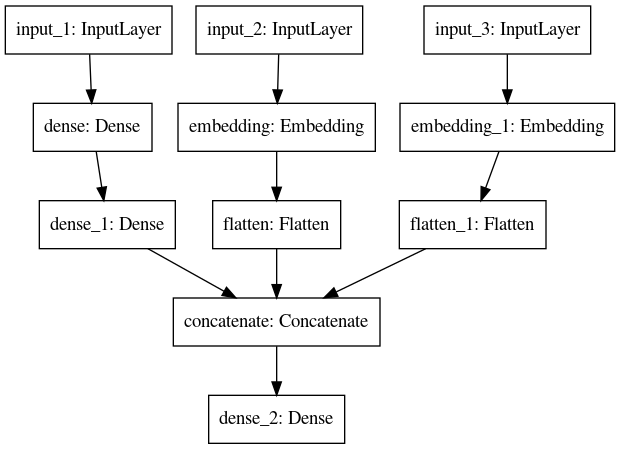

In [17]:
X_inputs = tf.keras.Input(shape=(X_train.shape[1],))
desc_inputs = tf.keras.Input(shape=(desc_train.shape[1],))
addr_inputs = tf.keras.Input(shape=(addr_train.shape[1],))

# X_inputs
X_dense1 = tf.keras.layers.Dense(128, activation='relu')(X_inputs)
X_dense2 = tf.keras.layers.Dense(128, activation='relu')(X_dense1)

# desc_inputs
desc_embedding = tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64,
    input_length=desc_train.shape[1]
)(desc_inputs)
desc_flatten = tf.keras.layers.Flatten()(desc_embedding)

# addr_inputs
addr_embedding = tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64,
    input_length=addr_train.shape[1]
)(addr_inputs)
addr_flatten = tf.keras.layers.Flatten()(addr_embedding)

# Concatenate results
concat = tf.keras.layers.concatenate([X_dense2, desc_flatten, addr_flatten])

# Make predictions
outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)


model = tf.keras.Model(inputs=[X_inputs, desc_inputs, addr_inputs], outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

# Training

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    [X_train, desc_train, addr_train],
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/20
875/875 [==============================] - 6s 6ms/step - loss: 0.1306 - accuracy: 0.9588 - val_loss: 0.0124 - val_accuracy: 0.9974
Epoch 2/20
875/875 [==============================] - 5s 6ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 3/20
875/875 [==============================] - 5s 6ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 4/20
875/875 [==============================] - 5s 6ms/step - loss: 8.7172e-04 - accuracy: 0.9998 - val_loss: 0.0041 - val_accuracy: 0.9991
Epoch 5/20
875/875 [==============================] - 5s 6ms/step - loss: 2.9445e-04 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9991
Epoch 6/20
875/875 [==============================] - 5s 6ms/step - loss: 1.2735e-04 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9991
Epoch 7/20
875/875 [==============================] - 5s 6ms/step - loss: 7.4012e-05 - accuracy: 1.0000 - val_loss: 0.0038 - val_accurac

# Results

In [19]:
results = model.evaluate([X_test, desc_test, addr_test], y_test, verbose=0)

In [20]:
print("Model loss: {:.5f}".format(results[0]))
print("Model accuracy: {:.2f}%".format(results[1] * 100))

Model loss: 0.00729
Model accuracy: 99.95%
